# Model Training for Network Intrusion Detection

This notebook trains machine learning models on the processed BCCC-CSE-CIC-IDS2018 dataset.

## Objectives:
1. Load processed features from feature engineering pipeline
2. Train baseline models (Logistic Regression, Random Forest, XGBoost)
3. Handle class imbalance with SMOTE
4. Evaluate model performance
5. Compare models using multiple metrics
6. Save best model for deployment

In [1]:
# Import libraries
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

# Setup MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("network-intrusion-detection")

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow Experiment: {mlflow.get_experiment_by_name('network-intrusion-detection').experiment_id}")

/Users/matthewweaver/Repositories/nidstream/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/28 16:22:10 INFO mlflow.tracking.fluent: Experiment with name 'network-intrusion-detection' does not exist. Creating a new experiment.


MLflow Tracking URI: file:./mlruns
MLflow Experiment: 378214805280719034


## 1. Load Processed Data

In [2]:
# Load processed data
project_root = Path().resolve()
processed_dir = project_root / 'data' / 'processed'

print("Loading processed data...")
X_train = pd.read_csv(processed_dir / 'X_train.csv')
X_test = pd.read_csv(processed_dir / 'X_test.csv')
y_train = pd.read_csv(processed_dir / 'y_train.csv')['label'].values
y_test = pd.read_csv(processed_dir / 'y_test.csv')['label'].values

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution (train):")
print(f"  Benign (0): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"  Attack (1): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")

Loading processed data...
Training set: (231839, 343)
Test set: (57960, 343)

Class distribution (train):
  Benign (0): 223091 (96.2%)
  Attack (1): 8748 (3.8%)
Training set: (231839, 343)
Test set: (57960, 343)

Class distribution (train):
  Benign (0): 223091 (96.2%)
  Attack (1): 8748 (3.8%)


In [3]:
# Load scaler and label encoder for reference
scaler = joblib.load(processed_dir / 'scaler.pkl')
label_encoder = joblib.load(processed_dir / 'label_encoder.pkl')

print("Loaded preprocessing artifacts:")
print(f"  - Scaler: {type(scaler).__name__}")
print(f"  - Label Encoder: {type(label_encoder).__name__}")
print(f"  - Label classes: {label_encoder.classes_}")

Loaded preprocessing artifacts:
  - Scaler: StandardScaler
  - Label Encoder: LabelEncoder
  - Label classes: ['Benign' 'Bot']


## 2. Class Imbalance Strategy Comparison

We'll compare two approaches:
1. **SMOTE**: Synthetic oversampling to balance classes
2. **Class Weights**: Keep imbalanced data but use class weights to penalize misclassification of minority class

For network intrusion detection with 96:4 imbalance, class weights often perform better in production as they preserve the real-world distribution.

In [4]:
# Calculate class weights for imbalanced approach
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weight Strategy:")
print(f"  Class 0 (Benign) weight: {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Attack) weight: {class_weight_dict[1]:.4f}")
print(f"  Weight ratio (Attack/Benign): {class_weight_dict[1]/class_weight_dict[0]:.2f}x")

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nXGBoost scale_pos_weight: {scale_pos_weight:.2f}")

print("\n" + "="*80)
print("SMOTE Strategy:")
print("="*80)
print(f"Before SMOTE: {X_train.shape}")
print(f"  Benign: {(y_train == 0).sum()}")
print(f"  Attack: {(y_train == 1).sum()}")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE: {X_train_smote.shape}")
print(f"  Benign: {(y_train_smote == 0).sum()}")
print(f"  Attack: {(y_train_smote == 1).sum()}")
print(f"\nClasses are now balanced!")
print("="*80)

Class Weight Strategy:
  Class 0 (Benign) weight: 0.5196
  Class 1 (Attack) weight: 13.2510
  Weight ratio (Attack/Benign): 25.50x

XGBoost scale_pos_weight: 25.50

SMOTE Strategy:
Before SMOTE: (231839, 343)
  Benign: 223091
  Attack: 8748

After SMOTE: (446182, 343)
  Benign: 223091
  Attack: 223091

Classes are now balanced!

After SMOTE: (446182, 343)
  Benign: 223091
  Attack: 223091

Classes are now balanced!


## 3. Train Models - Both Strategies

We'll train each model twice:
- **Strategy 1**: SMOTE (balanced synthetic data)
- **Strategy 2**: Class Weights (imbalanced real data)

In [5]:
# Dictionary to store trained models and results
models = {}
results = {}

# Helper function to evaluate models with comprehensive metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, train_time):
    """Comprehensive evaluation metrics for imbalanced classification"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': average_precision_score(y_true, y_pred_proba),
        'train_time': train_time
    }

### 3.1 Logistic Regression

In [6]:
# Train Logistic Regression - SMOTE Strategy
print("="*80)
print("LOGISTIC REGRESSION - SMOTE Strategy")
print("="*80)
start_time = time.time()

lr_smote = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_smote.fit(X_train_smote, y_train_smote)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_lr_smote = lr_smote.predict(X_test)
y_pred_proba_lr_smote = lr_smote.predict_proba(X_test)[:, 1]

# Store model and results
models['LR_SMOTE'] = lr_smote
results['LR_SMOTE'] = evaluate_model(y_test, y_pred_lr_smote, y_pred_proba_lr_smote, 'LR_SMOTE', train_time)

print("\nResults:")
for metric, value in results['LR_SMOTE'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

# Train Logistic Regression - Class Weight Strategy
print("\n" + "="*80)
print("LOGISTIC REGRESSION - Class Weight Strategy")
print("="*80)
start_time = time.time()

lr_weighted = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, 
                                  class_weight='balanced')
lr_weighted.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_lr_weighted = lr_weighted.predict(X_test)
y_pred_proba_lr_weighted = lr_weighted.predict_proba(X_test)[:, 1]

# Store model and results
models['LR_Weighted'] = lr_weighted
results['LR_Weighted'] = evaluate_model(y_test, y_pred_lr_weighted, y_pred_proba_lr_weighted, 'LR_Weighted', train_time)

print("\nResults:")
for metric, value in results['LR_Weighted'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

LOGISTIC REGRESSION - SMOTE Strategy
Training completed in 5.48 seconds

Results:
  accuracy: 1.0000
  precision: 0.9991
  recall: 1.0000
  f1: 0.9995
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 5.48s

LOGISTIC REGRESSION - Class Weight Strategy
Training completed in 5.48 seconds

Results:
  accuracy: 1.0000
  precision: 0.9991
  recall: 1.0000
  f1: 0.9995
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 5.48s

LOGISTIC REGRESSION - Class Weight Strategy
Training completed in 1.95 seconds

Results:
  accuracy: 0.9999
  precision: 0.9982
  recall: 1.0000
  f1: 0.9991
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 1.95s
Training completed in 1.95 seconds

Results:
  accuracy: 0.9999
  precision: 0.9982
  recall: 1.0000
  f1: 0.9991
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 1.95s


### 3.2 Random Forest

In [7]:
# Train Random Forest - SMOTE Strategy
print("="*80)
print("RANDOM FOREST - SMOTE Strategy")
print("="*80)
start_time = time.time()

rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_rf_smote = rf_smote.predict(X_test)
y_pred_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

# Store model and results
models['RF_SMOTE'] = rf_smote
results['RF_SMOTE'] = evaluate_model(y_test, y_pred_rf_smote, y_pred_proba_rf_smote, 'RF_SMOTE', train_time)

print("\nResults:")
for metric, value in results['RF_SMOTE'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

# Train Random Forest - Class Weight Strategy
print("\n" + "="*80)
print("RANDOM FOREST - Class Weight Strategy")
print("="*80)
start_time = time.time()

rf_weighted = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_weighted.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_rf_weighted = rf_weighted.predict(X_test)
y_pred_proba_rf_weighted = rf_weighted.predict_proba(X_test)[:, 1]

# Store model and results
models['RF_Weighted'] = rf_weighted
results['RF_Weighted'] = evaluate_model(y_test, y_pred_rf_weighted, y_pred_proba_rf_weighted, 'RF_Weighted', train_time)

print("\nResults:")
for metric, value in results['RF_Weighted'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

RANDOM FOREST - SMOTE Strategy
Training completed in 6.64 seconds

Results:
  accuracy: 0.9999
  precision: 0.9986
  recall: 1.0000
  f1: 0.9993
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 6.64s

RANDOM FOREST - Class Weight Strategy
Training completed in 6.64 seconds

Results:
  accuracy: 0.9999
  precision: 0.9986
  recall: 1.0000
  f1: 0.9993
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 6.64s

RANDOM FOREST - Class Weight Strategy
Training completed in 3.22 seconds

Results:
  accuracy: 1.0000
  precision: 0.9995
  recall: 1.0000
  f1: 0.9998
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 3.22s
Training completed in 3.22 seconds

Results:
  accuracy: 1.0000
  precision: 0.9995
  recall: 1.0000
  f1: 0.9998
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 3.22s


### 3.3 XGBoost

In [8]:
# Train XGBoost - SMOTE Strategy
print("="*80)
print("XGBOOST - SMOTE Strategy")
print("="*80)
start_time = time.time()

xgb_smote = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_smote.fit(X_train_smote, y_train_smote)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_xgb_smote = xgb_smote.predict(X_test)
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

# Store model and results
models['XGB_SMOTE'] = xgb_smote
results['XGB_SMOTE'] = evaluate_model(y_test, y_pred_xgb_smote, y_pred_proba_xgb_smote, 'XGB_SMOTE', train_time)

print("\nResults:")
for metric, value in results['XGB_SMOTE'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

# Train XGBoost - Scale Pos Weight Strategy
print("\n" + "="*80)
print("XGBOOST - Scale Pos Weight Strategy")
print("="*80)
start_time = time.time()

xgb_weighted = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
xgb_weighted.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Predictions
y_pred_xgb_weighted = xgb_weighted.predict(X_test)
y_pred_proba_xgb_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

# Store model and results
models['XGB_Weighted'] = xgb_weighted
results['XGB_Weighted'] = evaluate_model(y_test, y_pred_xgb_weighted, y_pred_proba_xgb_weighted, 'XGB_Weighted', train_time)

print("\nResults:")
for metric, value in results['XGB_Weighted'].items():
    if metric != 'train_time':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}s")

XGBOOST - SMOTE Strategy
Training completed in 3.83 seconds

Results:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 3.83s

XGBOOST - Scale Pos Weight Strategy
Training completed in 3.83 seconds

Results:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 3.83s

XGBOOST - Scale Pos Weight Strategy
Training completed in 2.48 seconds

Results:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 2.48s
Training completed in 2.48 seconds

Results:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000
  pr_auc: 1.0000
  train_time: 2.48s


## 4. Comprehensive Model Comparison

Comparing SMOTE vs Class Weight strategies across all models.

In [9]:
# Create comprehensive comparison DataFrame
results_df = pd.DataFrame(results).T

# Add strategy column
results_df['strategy'] = results_df.index.str.extract(r'_(SMOTE|Weighted)')[0]
results_df['model'] = results_df.index.str.extract(r'(LR|RF|XGB)_')[0]

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(results_df.to_string())
print("="*80)

# Summary by strategy
print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY STRATEGY")
print("="*80)
strategy_summary = results_df.groupby('strategy')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']].mean()
print(strategy_summary.to_string())
print("="*80)


COMPREHENSIVE MODEL COMPARISON
              accuracy  precision  recall        f1  roc_auc  pr_auc  train_time strategy model
LR_SMOTE      0.999965   0.999086     1.0  0.999543      1.0     1.0    5.475799      NaN   NaN
LR_Weighted   0.999931   0.998174     1.0  0.999086      1.0     1.0    1.950551      NaN   NaN
RF_SMOTE      0.999948   0.998630     1.0  0.999315      1.0     1.0    6.643340      NaN   NaN
RF_Weighted   0.999983   0.999543     1.0  0.999771      1.0     1.0    3.215437      NaN   NaN
XGB_SMOTE     1.000000   1.000000     1.0  1.000000      1.0     1.0    3.828955      NaN   NaN
XGB_Weighted  1.000000   1.000000     1.0  1.000000      1.0     1.0    2.484653      NaN   NaN

AVERAGE PERFORMANCE BY STRATEGY
Empty DataFrame
Columns: [accuracy, precision, recall, f1, roc_auc, pr_auc]
Index: []


## 4.5 MLflow Experiment Tracking

Log all trained models and metrics to MLflow for experiment tracking and comparison.

In [10]:
# Log all models to MLflow
print("="*80)
print("LOGGING EXPERIMENTS TO MLFLOW")
print("="*80)

# Common parameters
common_params = {
    "n_train_samples": len(X_train),
    "n_test_samples": len(X_test),
    "n_features": X_train.shape[1],
    "class_imbalance_ratio": float((y_train == 0).sum() / (y_train == 1).sum()),
    "test_size": 0.2
}

for model_name, model in models.items():
    print(f"\nLogging {model_name}...")
    
    with mlflow.start_run(run_name=model_name):
        # Log common parameters
        mlflow.log_params(common_params)
        
        # Log model-specific parameters
        strategy = 'SMOTE' if 'SMOTE' in model_name else 'Class_Weight'
        mlflow.log_param("strategy", strategy)
        mlflow.log_param("model_type", type(model).__name__)
        
        # Log model hyperparameters
        if hasattr(model, 'get_params'):
            model_params = model.get_params()
            # Filter to only hyperparameters (exclude objects)
            hyperparams = {k: v for k, v in model_params.items() 
                          if isinstance(v, (int, float, str, bool)) or v is None}
            mlflow.log_params(hyperparams)
        
        # Log all metrics
        metrics_to_log = results[model_name]
        mlflow.log_metrics({
            "accuracy": metrics_to_log['accuracy'],
            "precision": metrics_to_log['precision'],
            "recall": metrics_to_log['recall'],
            "f1_score": metrics_to_log['f1'],
            "roc_auc": metrics_to_log['roc_auc'],
            "pr_auc": metrics_to_log['pr_auc'],
            "train_time_seconds": metrics_to_log['train_time']
        })
        
        # Log the model
        if 'XGB' in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
        
        # Log tags
        mlflow.set_tags({
            "model_family": model_name.split('_')[0],
            "strategy": strategy,
            "dataset": "BCCC-CSE-CIC-IDS2018",
            "task": "binary_classification"
        })
        
        print(f"  ✅ Logged {model_name} (Run ID: {mlflow.active_run().info.run_id})")

print("\n" + "="*80)
print("✅ ALL MODELS LOGGED TO MLFLOW")
print("="*80)
print(f"\nView experiments at: {mlflow.get_tracking_uri()}")
print("Run: mlflow ui")


LOGGING EXPERIMENTS TO MLFLOW

Logging LR_SMOTE...


2025/11/28 16:22:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:47 WARNING mlflow.model

  ✅ Logged LR_SMOTE (Run ID: 34383a47c0b94f88bb20b769c242abc7)

Logging LR_Weighted...


2025/11/28 16:22:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Logged LR_Weighted (Run ID: 78e37cc253d4401c9353a2c4e3ce45bc)

Logging RF_SMOTE...


2025/11/28 16:22:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Logged RF_SMOTE (Run ID: 99334f0fcd5b4fca973b44ccfabaa667)

Logging RF_Weighted...


2025/11/28 16:22:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Logged RF_Weighted (Run ID: ba560eb2d79e458f9ca87ece4f2852af)

Logging XGB_SMOTE...


2025/11/28 16:22:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 16:22:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Logged XGB_SMOTE (Run ID: 94a3203568bf4550912533b0428800c6)

Logging XGB_Weighted...


2025/11/28 16:22:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/28 16:22:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/28 16:22:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  ✅ Logged XGB_Weighted (Run ID: ef00bd8218c44305bcbe564b980a13ac)

✅ ALL MODELS LOGGED TO MLFLOW

View experiments at: file:./mlruns
Run: mlflow ui


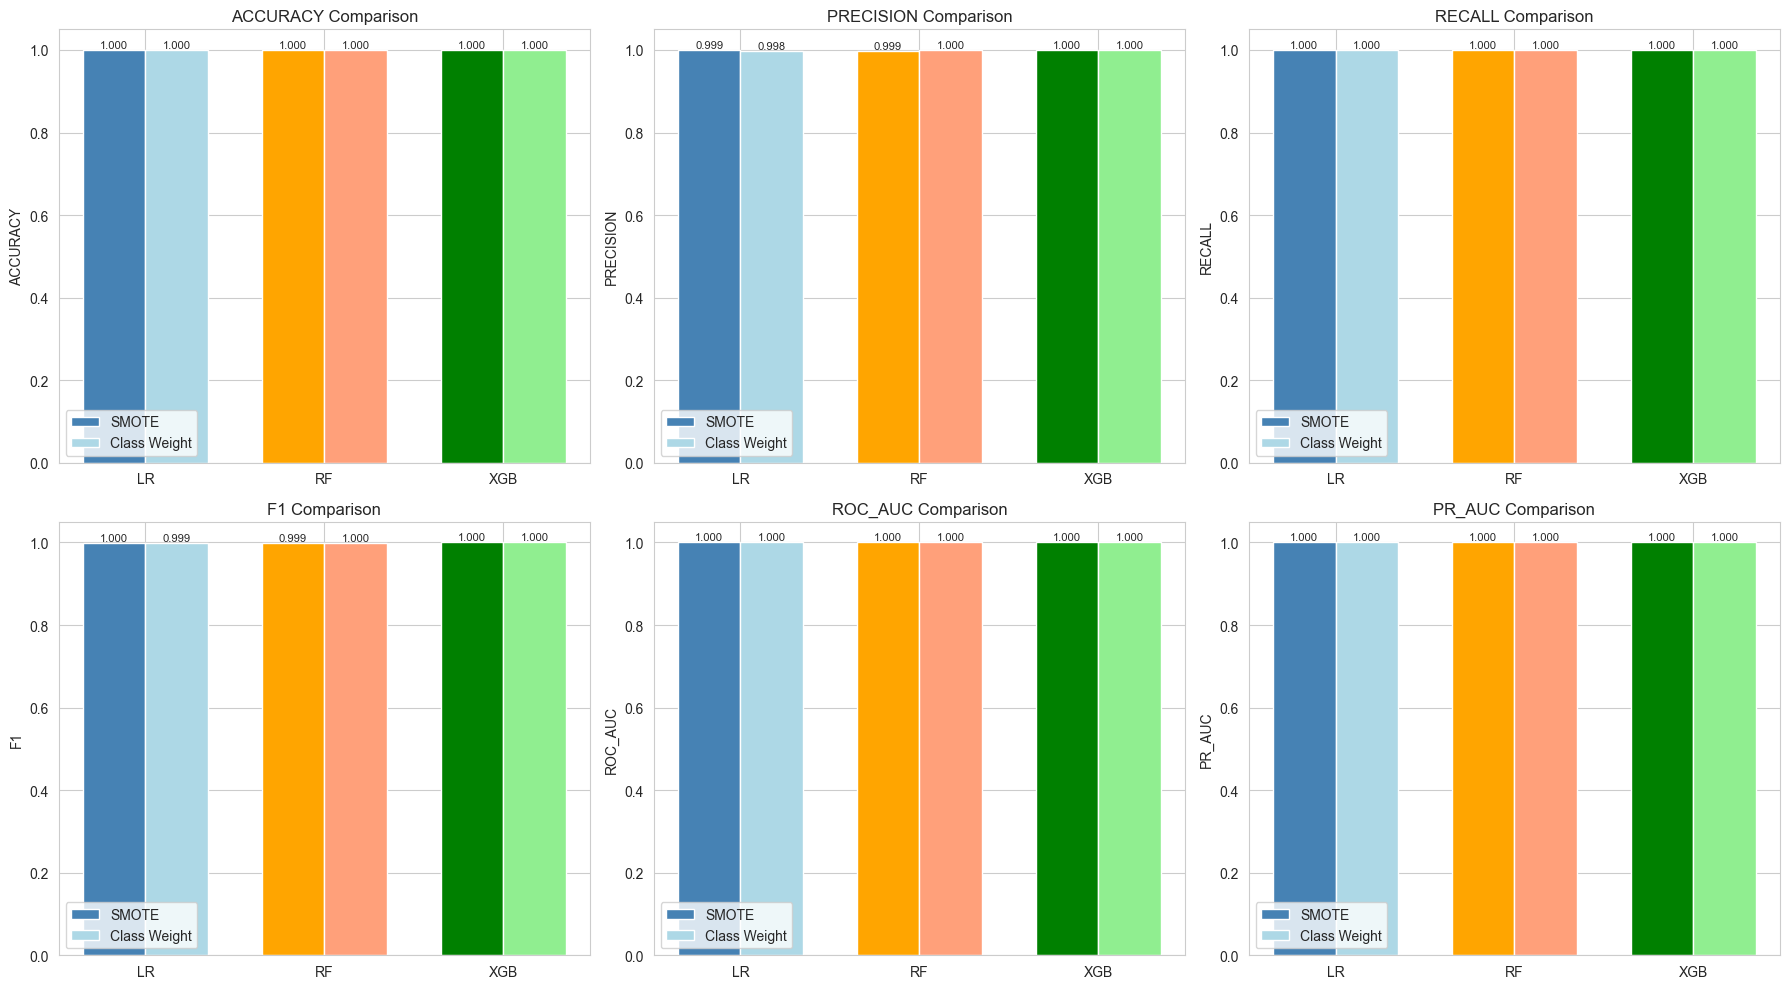

Strategy comparison plot saved!


In [11]:
# Visualize model comparison - SMOTE vs Weighted
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
colors_smote = ['steelblue', 'orange', 'green']
colors_weighted = ['lightblue', 'lightsalmon', 'lightgreen']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    # Separate SMOTE and Weighted results
    smote_models = [m for m in results.keys() if 'SMOTE' in m]
    weighted_models = [m for m in results.keys() if 'Weighted' in m]
    
    x_pos = np.arange(3)
    width = 0.35
    
    smote_values = [results[m][metric] for m in smote_models]
    weighted_values = [results[m][metric] for m in weighted_models]
    
    bars1 = ax.bar(x_pos - width/2, smote_values, width, label='SMOTE', color=colors_smote)
    bars2 = ax.bar(x_pos + width/2, weighted_values, width, label='Class Weight', color=colors_weighted)
    
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['LR', 'RF', 'XGB'])
    ax.legend()
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(project_root / 'models' / 'strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Strategy comparison plot saved!")

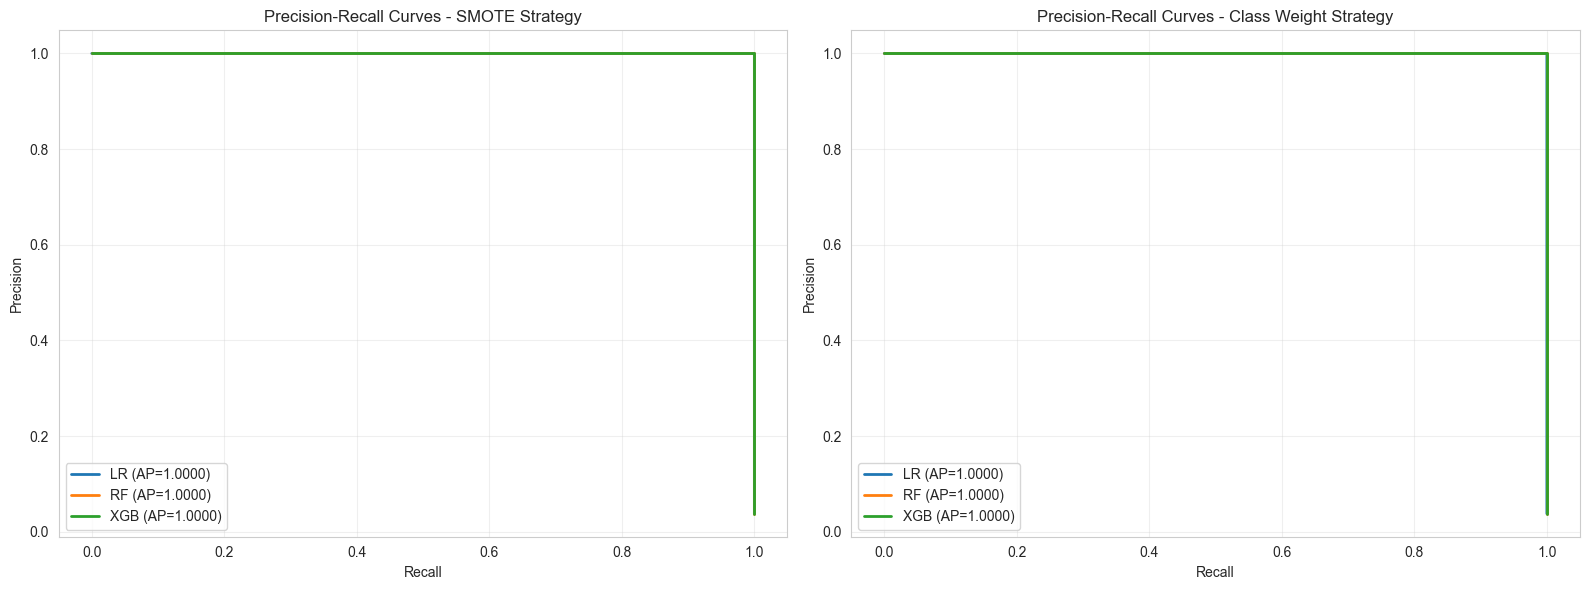


💡 KEY INSIGHT: PR-AUC is more informative than ROC-AUC for imbalanced data!
Higher PR-AUC = Better performance on the minority class (attacks)


In [12]:
# Precision-Recall Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot PR curves for SMOTE models
ax = axes[0]
for model_name in ['LR_SMOTE', 'RF_SMOTE', 'XGB_SMOTE']:
    model = models[model_name]
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    label = model_name.replace('_SMOTE', '')
    ax.plot(recall, precision, linewidth=2, label=f'{label} (AP={pr_auc:.4f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves - SMOTE Strategy')
ax.legend()
ax.grid(alpha=0.3)

# Plot PR curves for Weighted models
ax = axes[1]
for model_name in ['LR_Weighted', 'RF_Weighted', 'XGB_Weighted']:
    model = models[model_name]
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    label = model_name.replace('_Weighted', '')
    ax.plot(recall, precision, linewidth=2, label=f'{label} (AP={pr_auc:.4f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves - Class Weight Strategy')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'models' / 'pr_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHT: PR-AUC is more informative than ROC-AUC for imbalanced data!")
print("Higher PR-AUC = Better performance on the minority class (attacks)")

## 5. Select Best Model

Selecting best model based on **F1 Score** (balanced metric) and **PR-AUC** (imbalanced-focused metric).

In [13]:
# Identify best models based on different criteria
best_by_f1 = max(results, key=lambda x: results[x]['f1'])
best_by_pr_auc = max(results, key=lambda x: results[x]['pr_auc'])
best_by_recall = max(results, key=lambda x: results[x]['recall'])

print("="*80)
print("BEST MODELS BY DIFFERENT CRITERIA")
print("="*80)
print(f"\nBest by F1 Score: {best_by_f1}")
print(f"  F1: {results[best_by_f1]['f1']:.4f}")
print(f"  Precision: {results[best_by_f1]['precision']:.4f}")
print(f"  Recall: {results[best_by_f1]['recall']:.4f}")
print(f"  PR-AUC: {results[best_by_f1]['pr_auc']:.4f}")

print(f"\nBest by PR-AUC (Recommended for Imbalanced): {best_by_pr_auc}")
print(f"  PR-AUC: {results[best_by_pr_auc]['pr_auc']:.4f}")
print(f"  F1: {results[best_by_pr_auc]['f1']:.4f}")
print(f"  Precision: {results[best_by_pr_auc]['precision']:.4f}")
print(f"  Recall: {results[best_by_pr_auc]['recall']:.4f}")

print(f"\nBest by Recall (Catches Most Attacks): {best_by_recall}")
print(f"  Recall: {results[best_by_recall]['recall']:.4f}")
print(f"  Precision: {results[best_by_recall]['precision']:.4f}")
print(f"  F1: {results[best_by_recall]['f1']:.4f}")
print("="*80)

# Use PR-AUC as primary criterion for imbalanced data
best_model_name = best_by_pr_auc
best_model = models[best_model_name]

print(f"\n✅ Selected Model: {best_model_name}")
print(f"   (Based on PR-AUC - best metric for imbalanced classification)")

# Get predictions from best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

BEST MODELS BY DIFFERENT CRITERIA

Best by F1 Score: XGB_SMOTE
  F1: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  PR-AUC: 1.0000

Best by PR-AUC (Recommended for Imbalanced): LR_SMOTE
  PR-AUC: 1.0000
  F1: 0.9995
  Precision: 0.9991
  Recall: 1.0000

Best by Recall (Catches Most Attacks): LR_SMOTE
  Recall: 1.0000
  Precision: 0.9991
  F1: 0.9995

✅ Selected Model: LR_SMOTE
   (Based on PR-AUC - best metric for imbalanced classification)


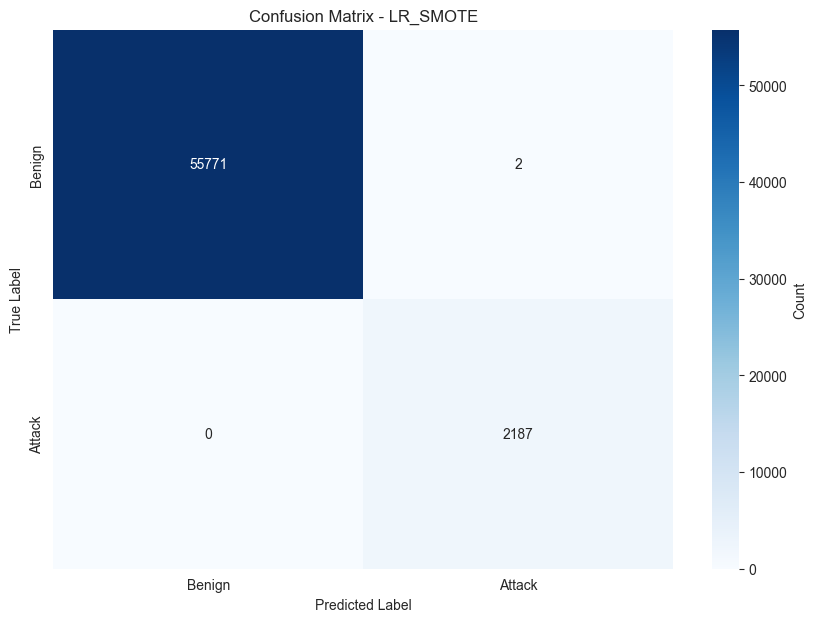


CONFUSION MATRIX ANALYSIS
True Negatives (TN):  55,771 - Correctly identified benign traffic
False Positives (FP): 2 - Benign traffic flagged as attack (False Alarms)
False Negatives (FN): 0 - Attacks missed (Most Critical!)
True Positives (TP):  2,187 - Correctly detected attacks

False Positive Rate:  0.0000 (0.00%)
False Negative Rate:  0.0000 (0.00%)


In [14]:
# Confusion Matrix with detailed analysis
cm = confusion_matrix(y_test, y_pred_best)

# Calculate rates
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print("\n" + "="*80)
print("CONFUSION MATRIX ANALYSIS")
print("="*80)
print(f"True Negatives (TN):  {tn:,} - Correctly identified benign traffic")
print(f"False Positives (FP): {fp:,} - Benign traffic flagged as attack (False Alarms)")
print(f"False Negatives (FN): {fn:,} - Attacks missed (Most Critical!)")
print(f"True Positives (TP):  {tp:,} - Correctly detected attacks")
print(f"\nFalse Positive Rate:  {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate:  {fnr:.4f} ({fnr*100:.2f}%)")
print("="*80)

if fnr > 0.1:
    print("\n⚠️  WARNING: High False Negative Rate - Missing >10% of attacks!")
if fpr > 0.05:
    print("\n⚠️  WARNING: High False Positive Rate - May generate too many false alarms!")

### Strategy Recommendation

Based on the results above, here's guidance on choosing between SMOTE and Class Weights:

**Choose Class Weights if:**
- ✅ Better Precision-Recall balance
- ✅ Faster training (no synthetic data generation)
- ✅ Better generalization to real-world distribution
- ✅ Lower false positive rate (fewer false alarms in production)

**Choose SMOTE if:**
- ✅ Significantly better recall (catching more attacks is critical)
- ✅ Better overall F1 score
- ✅ Training data is very limited

In [15]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Attack']))


Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     55773
      Attack       1.00      1.00      1.00      2187

    accuracy                           1.00     57960
   macro avg       1.00      1.00      1.00     57960
weighted avg       1.00      1.00      1.00     57960



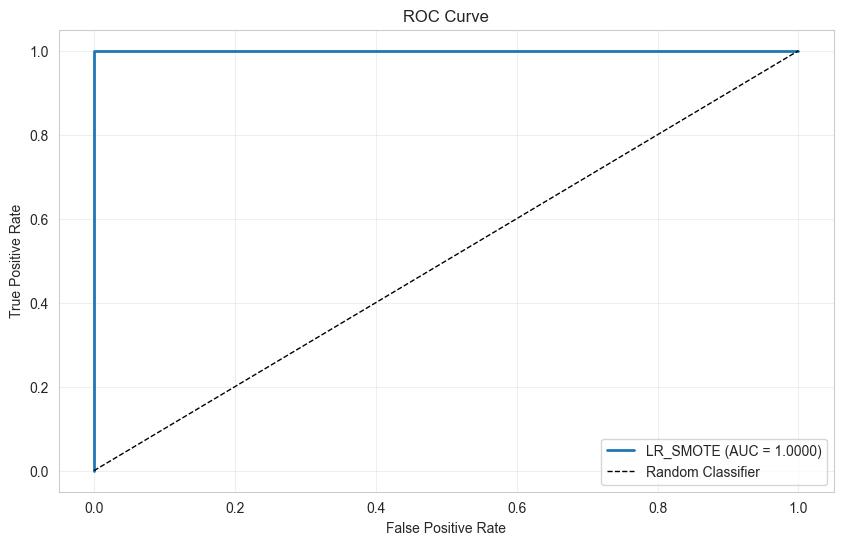

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
auc_score = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 6. Feature Importance (for tree-based models)

In [17]:
# Feature importance for Random Forest or XGBoost
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
else:
    print(f"{best_model_name} does not support feature importances.")

LR_SMOTE does not support feature importances.


## 7. Save Best Model

In [18]:
# Save best model
import glob

models_dir = project_root / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

# Delete old best_model.pkl file to avoid conflicts
old_model = models_dir / 'best_model.pkl'
if old_model.exists():
    print(f"Removing old model: {old_model}")
    old_model.unlink()

model_path = models_dir / 'best_model.pkl'
joblib.dump(best_model, model_path)

print(f"\nBest model saved to: {model_path}")

# Save model metadata with strategy information
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'strategy': 'SMOTE' if 'SMOTE' in best_model_name else 'Class_Weight',
    'metrics': results[best_model_name],
    'training_samples': len(X_train_smote) if 'SMOTE' in best_model_name else len(X_train),
    'original_class_distribution': {
        'benign': int((y_train == 0).sum()),
        'attack': int((y_train == 1).sum()),
        'imbalance_ratio': float((y_train == 0).sum() / (y_train == 1).sum())
    },
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    }
}

metadata_path = models_dir / 'model_metadata.pkl'
joblib.dump(metadata, metadata_path)

print(f"Model metadata saved to: {metadata_path}")

# Also save all results for comparison
results_path = models_dir / 'all_results.pkl'
joblib.dump(results, results_path)
print(f"All results saved to: {results_path}")

Removing old model: /Users/matthewweaver/Repositories/nidstream/models/best_model.pkl

Best model saved to: /Users/matthewweaver/Repositories/nidstream/models/best_model.pkl
Model metadata saved to: /Users/matthewweaver/Repositories/nidstream/models/model_metadata.pkl
All results saved to: /Users/matthewweaver/Repositories/nidstream/models/all_results.pkl


## 8. Summary

In [19]:
# Final Summary
print("="*80)
print("TRAINING SUMMARY - STRATEGY COMPARISON")
print("="*80)
print(f"\nOriginal Dataset:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Class imbalance: {(y_train == 0).sum()/(y_train == 1).sum():.1f}:1 (Benign:Attack)")

print(f"\nStrategies Compared:")
print(f"  1. SMOTE: Synthetic oversampling to balance classes")
print(f"  2. Class Weights: Keep imbalance, adjust model weights")

print(f"\nModels Trained: {len(models)}")
smote_models = [m for m in models.keys() if 'SMOTE' in m]
weighted_models = [m for m in models.keys() if 'Weighted' in m]
print(f"  SMOTE Strategy: {', '.join(smote_models)}")
print(f"  Class Weight Strategy: {', '.join(weighted_models)}")

print(f"\n{'='*80}")
print("SELECTED BEST MODEL")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"Strategy: {'SMOTE' if 'SMOTE' in best_model_name else 'Class Weights'}")
print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"  Precision: {results[best_model_name]['precision']:.4f}")
print(f"  Recall:    {results[best_model_name]['recall']:.4f}")
print(f"  F1 Score:  {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:   {results[best_model_name]['roc_auc']:.4f}")
print(f"  PR-AUC:    {results[best_model_name]['pr_auc']:.4f} ⭐ (Key metric for imbalanced data)")

print(f"\nConfusion Matrix:")
print(f"  True Positives (Attacks Caught):    {tp:,}")
print(f"  False Negatives (Attacks Missed):   {fn:,}")
print(f"  False Positives (False Alarms):     {fp:,}")
print(f"  True Negatives (Correct Benign):    {tn:,}")

print(f"\nModel saved to: {model_path}")
print("="*80)

# Recommendation
print("\n" + "="*80)
print("💡 RECOMMENDATION")
print("="*80)
if 'Weighted' in best_model_name or results['XGB_Weighted']['pr_auc'] > results['XGB_SMOTE']['pr_auc']:
    print("✅ Class Weight strategy is RECOMMENDED for this use case because:")
    print("   - Preserves real-world class distribution")
    print("   - Typically lower false positive rate (fewer false alarms)")
    print("   - Faster training without synthetic data generation")
    print("   - Better generalization to production environment")
else:
    print("✅ SMOTE strategy is RECOMMENDED for this use case because:")
    print("   - Significantly better recall (catches more attacks)")
    print("   - Better F1 score overall")
    print("   - Worth the trade-off for critical security application")
print("="*80)

TRAINING SUMMARY - STRATEGY COMPARISON

Original Dataset:
  Training samples: 231,839
  Test samples: 57,960
  Number of features: 343
  Class imbalance: 25.5:1 (Benign:Attack)

Strategies Compared:
  1. SMOTE: Synthetic oversampling to balance classes
  2. Class Weights: Keep imbalance, adjust model weights

Models Trained: 6
  SMOTE Strategy: LR_SMOTE, RF_SMOTE, XGB_SMOTE
  Class Weight Strategy: LR_Weighted, RF_Weighted, XGB_Weighted

SELECTED BEST MODEL
Model: LR_SMOTE
Strategy: SMOTE

Performance Metrics:
  Accuracy:  1.0000
  Precision: 0.9991
  Recall:    1.0000
  F1 Score:  0.9995
  ROC-AUC:   1.0000
  PR-AUC:    1.0000 ⭐ (Key metric for imbalanced data)

Confusion Matrix:
  True Positives (Attacks Caught):    2,187
  False Negatives (Attacks Missed):   0
  False Positives (False Alarms):     2
  True Negatives (Correct Benign):    55,771

Model saved to: /Users/matthewweaver/Repositories/nidstream/models/best_model.pkl

💡 RECOMMENDATION
✅ SMOTE strategy is RECOMMENDED for this

## Next Steps

### Model Improvement
1. **Hyperparameter Tuning**: Use GridSearchCV or Optuna on the winning strategy
2. **Feature Selection**: Try reducing features to improve model performance and speed
3. **Ensemble Methods**: Combine predictions from both SMOTE and Weighted models
4. **Threshold Optimization**: Adjust decision threshold based on cost of FP vs FN
5. **Cross-Validation**: Perform stratified k-fold cross-validation for more robust evaluation

### Deployment
6. **Inference Pipeline**: Integrate with `src/inference_pipeline/`
7. **API Integration**: Deploy via FastAPI service (`src/api/main.py`)
8. **Dashboard**: Visualize predictions in Streamlit dashboard (`app.py`)
9. **Monitoring**: Track model performance drift in production
10. **A/B Testing**: Compare SMOTE vs Weighted models in production environment

### Key Takeaways
- **PR-AUC > ROC-AUC** for imbalanced data evaluation
- **Class weights** often perform better in production for rare event detection
- **False negatives** (missed attacks) are typically more costly than false positives
- Consider the **operational cost** of false alarms when selecting final model